# End Sem Lab Exam

### CS22B1093 Rohan G

### Q3 - A2C in LunarLander

-----------------------------

Episode 100, Avg Reward: -275.33, Actor Loss: -27310.225, Critic Loss: 40933.812
Episode 200, Avg Reward: -242.65, Actor Loss: -16758.172, Critic Loss: 14072.220
Episode 300, Avg Reward: -271.72, Actor Loss: -13880.332, Critic Loss: 11634.162
Episode 400, Avg Reward: -221.59, Actor Loss: -10627.177, Critic Loss: 11768.938
Episode 500, Avg Reward: -218.41, Actor Loss: -12933.428, Critic Loss: 11852.115
Episode 600, Avg Reward: -204.98, Actor Loss: -6527.362, Critic Loss: 3573.809
Episode 700, Avg Reward: -221.96, Actor Loss: -10147.453, Critic Loss: 2136.511
Episode 800, Avg Reward: -225.48, Actor Loss: -9387.417, Critic Loss: 4664.952
Episode 900, Avg Reward: -183.77, Actor Loss: 7457.233, Critic Loss: 2776.620
Episode 1000, Avg Reward: -206.13, Actor Loss: 5566.572, Critic Loss: 2410.999


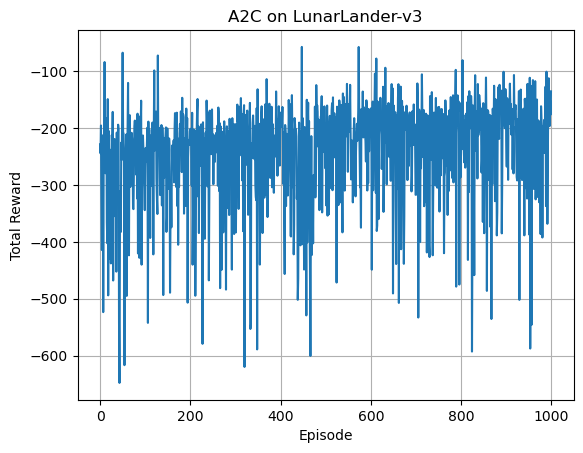

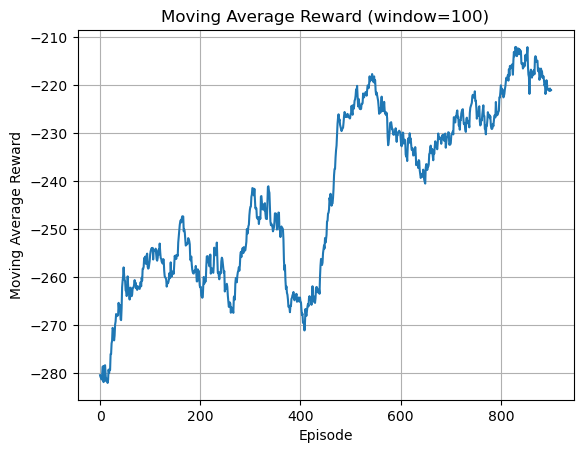

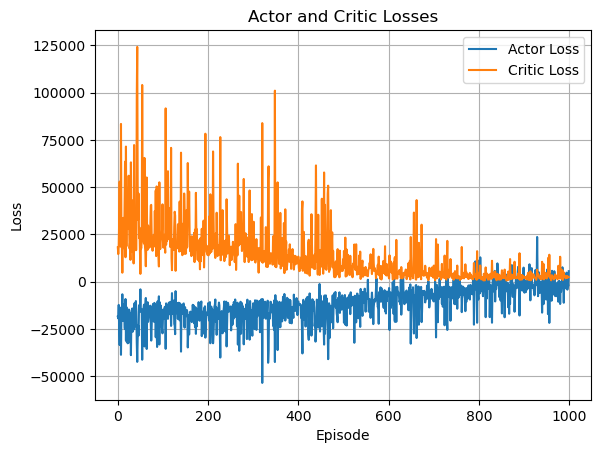

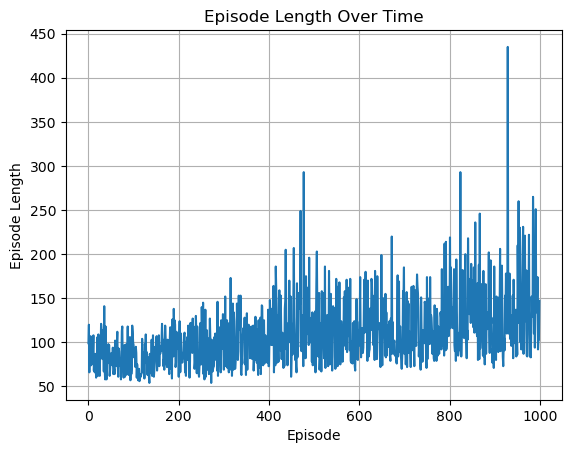

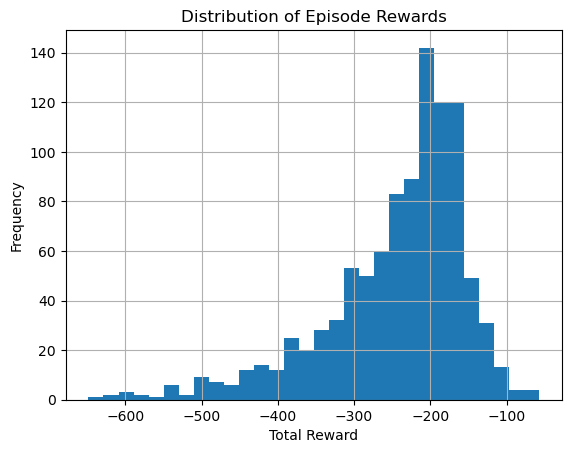

In [ ]:
# importing necessary libraries
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Hyperparameters
lr = 0.0005
gamma = 0.99
num_episodes = 1000
max_timesteps = 1000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Creating the Environment
env = gym.make("LunarLander-v3")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# defining the Actor and Critic classes
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.ReLU(),
            nn.Linear(256, action_dim),
            nn.Softmax(dim=-1)
        )

    def forward(self, state):
        return self.fc(state)

class Critic(nn.Module):
    def __init__(self, state_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, state):
        return self.fc(state)

class A2CAgent:
    def __init__(self, state_dim, action_dim):
        self.actor = Actor(state_dim, action_dim).to(device)
        self.critic = Critic(state_dim).to(device)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=lr)

    def select_action(self, state):
        state = torch.FloatTensor(state).to(device)
        probs = self.actor(state)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()
        return action.item(), dist.log_prob(action)

    # function to collect experiences from the environment
    def collect_experiences(self, env):
        states, actions, log_probs, rewards, dones = [], [], [], [], []
        state, _ = env.reset()
        total_reward = 0

        for _ in range(max_timesteps):
            action, log_prob = self.select_action(state)
            next_state, reward, done, truncated, info = env.step(action)

            # Reward shaping: +100 for landing, -100 for crashing
            if done:
                if reward == 100:
                    reward += 100
                elif reward == -100:
                    reward -= 100

            states.append(state)
            actions.append(action)
            log_probs.append(log_prob)
            rewards.append(reward)
            dones.append(done)

            state = next_state
            total_reward += reward

            if done or truncated:
                break

        return states, actions, log_probs, rewards, dones, total_reward

    # function to compute the returns
    def compute_returns(self, rewards, dones):
        returns = []
        G = 0
        for reward, done in zip(reversed(rewards), reversed(dones)):
            if done:
                G = 0
            G = reward + gamma * G
            returns.insert(0, G)
        return returns

    # function to update the actor and critic networks
    def update_actor_critic(self, states, log_probs, rewards, dones):
        returns = self.compute_returns(rewards, dones)
        returns = torch.FloatTensor(returns).to(device)
        states_tensor = torch.FloatTensor(states).to(device)
        values = self.critic(states_tensor).squeeze()
        advantages = returns - values.detach()

        # Actor loss
        actor_loss = -torch.stack(log_probs) * advantages
        actor_loss = actor_loss.sum()

        # Critic loss
        critic_loss = (returns - values).pow(2).mean()

        # Update actor
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Update critic
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        return actor_loss.item(), critic_loss.item()

# Initializing agent
agent = A2CAgent(state_dim, action_dim)

# Tracking lists for additional plots
episode_rewards = []
actor_losses = []
critic_losses = []
episode_lengths = []

# Training loop
for episode in range(num_episodes):
    states, actions, log_probs, rewards, dones, total_reward = agent.collect_experiences(env)
    actor_loss, critic_loss = agent.update_actor_critic(states, log_probs, rewards, dones)
    episode_rewards.append(total_reward)
    actor_losses.append(actor_loss)
    critic_losses.append(critic_loss)
    episode_lengths.append(len(rewards))

    if (episode + 1) % 100 == 0:
        avg_reward = np.mean(episode_rewards[-20:])
        print(f"Episode {episode+1}, Avg Reward: {avg_reward:.2f}, Actor Loss: {actor_loss:.3f}, Critic Loss: {critic_loss:.3f}")

# Ploting total rewards per episode
plt.figure()
plt.plot(episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('A2C on LunarLander-v3')
plt.grid()
plt.show()

# Ploting moving average reward
window = 100
if len(episode_rewards) >= window:
    moving_avg = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')
    plt.figure()
    plt.plot(moving_avg)
    plt.xlabel('Episode')
    plt.ylabel('Moving Average Reward')
    plt.title(f'Moving Average Reward (window={window})')
    plt.grid()
    plt.show()

# Ploting actor and critic losses
plt.figure()
plt.plot(actor_losses, label='Actor Loss')
plt.plot(critic_losses, label='Critic Loss')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('Actor and Critic Losses')
plt.legend()
plt.grid()
plt.show()

# Ploting episode lengths
plt.figure()
plt.plot(episode_lengths)
plt.xlabel('Episode')
plt.ylabel('Episode Length')
plt.title('Episode Length Over Time')
plt.grid()
plt.show()

# Ploting histogram of rewards
plt.figure()
plt.hist(episode_rewards, bins=30)
plt.xlabel('Total Reward')
plt.ylabel('Frequency')
plt.title('Distribution of Episode Rewards')
plt.grid()
plt.show()

-----------------------